# Hoh River tiles

## In collaboration with the Hoh Indian Tribe

Under development for the [Cascadia CoPes Hub](https://cascadiacopeshub.org/) project, supported by NSF.

In [2]:
%matplotlib inline

In [3]:
from pylab import *
from clawpack.geoclaw import topotools
from clawpack.visclaw import geoplot
from importlib import reload
import geopandas as gpd
import folium
import pandas as pd
import merge_topos

In [4]:
import find_topo_source

List of catalogs found in topo_sources_cascadia.md:
  Catalog =  https://www.ngdc.noaa.gov/thredds/catalog/crm/catalog.html
  Catalog =  https://www.ngdc.noaa.gov/thredds/catalog/regional/catalog.html
  Catalog =  https://www.ngdc.noaa.gov/thredds/catalog/pmel/catalog.html
  Catalog =  https://www.ngdc.noaa.gov/thredds/catalog/tiles/tiled_19as/catalog.html
  Catalog =  https://www.ngdc.noaa.gov/thredds/catalog/tiles/tiled_13as/catalog.html
  Catalog =  https://www.ngdc.noaa.gov/thredds/catalog/tiles/nthmp/tiled_19as/catalog.html
  Catalog =  https://coast.noaa.gov/htdata/raster2/elevation/NCEI_ninth_Topobathy_2014_8483/
  Catalog =  https://coast.noaa.gov/htdata/raster2/elevation/NCEI_ninth_Topobathy_2014_8483/index.html
  Catalog =  https://coast.noaa.gov/htdata/raster2/elevation/NCEI_ninth_Topobathy_2014_8483/wash_bellingham/index.html
  Catalog =  https://coast.noaa.gov/htdata/raster2/elevation/NCEI_ninth_Topobathy_2014_8483/wash_juandefuca/index.html
  Catalog =  https://coast.noaa

In [5]:
eighth = 1/8  # half tile width
yrange = arange(47.75, 48.00+eighth, 0.25)
xrange = arange(-124.5, -124.5+eighth, 0.25)
name = 'NCEI tiles around Hoh River'
find_topo_source.make_combined_tile_kml(name, xrange, yrange)

Created  NCEI_tiles_around_Hoh_River.kml


In [6]:
tile_names = []
for x in xrange:
    for y in yrange:
        xm = x+eighth
        ym = y-eighth
        tile_name = find_topo_source.tile_coords(xm,ym,verbose=False)
        print(f'midpoints: {xm:.3f}, {ym:.3f}, NW corner:  {x:.3f}, {y:.3f}, tile: {tile_name}')
        tile_names.append(tile_name)

midpoints: -124.375, 47.625, NW corner:  -124.500, 47.750, tile: n47x75_w124x50
midpoints: -124.375, 47.875, NW corner:  -124.500, 48.000, tile: n48x00_w124x50


In [7]:
gdf = gpd.read_file('NCEI_tiles_around_Hoh_River.kml', driver='KML')
m = folium.Map(location=(47.75,-124.43), zoom_start=10, scrollWheelZoom=False)
folium.GeoJson(gdf).add_to(m)

for x in xrange:
    for y in yrange:
        xm = x+eighth
        ym = y-eighth
        tile_name = find_topo_source.tile_coords(xm,ym,verbose=False)
        folium.Marker(
            location=[y-eighth,x+eighth],
            #popup = f"{x:.3f}, {y:.3f}: \n<b>Tile:</b>\n {tile_name}",
            popup = f"<b>Tile:</b>\n {tile_name}",
            tooltip="Click for info",
            icon=folium.Icon(color="red")  #, icon="cloud") # Customize the marker's appearance
        ).add_to(m) 
m

In [8]:
for tile_name in tile_names:
    print('\n-----------------------------------')
    tile_urls = find_topo_source.find_tile_url(tile_name, verbose=True)
    if len(tile_urls) == 0:
        print(f'{tile_name} not found')


-----------------------------------

  n47x75_w124x50 found in:
    Catalog:  https://www.ngdc.noaa.gov/thredds/catalog/tiles/tiled_19as/catalog.html
    URL:  https://www.ngdc.noaa.gov/thredds/dodsC/tiles/tiled_19as/ncei19_n47x75_w0124x50_2018v1.nc

  n47x75_w124x50 found in:
    Catalog:  https://www.ngdc.noaa.gov/thredds/catalog/tiles/nthmp/tiled_19as/catalog.html
    URL:  https://www.ngdc.noaa.gov/thredds/dodsC/tiles/nthmp/tiled_19as/ncei19_n47x75_w0124x50_2020.nc

  n47x75_w124x50 found in:
    Catalog:  https://coast.noaa.gov/htdata/raster2/elevation/NCEI_ninth_Topobathy_2014_8483/wash_outercoast/index.html
    URL:  https://coast.noaa.gov/htdata/raster2/elevation/NCEI_ninth_Topobathy_2014_8483/wash_outercoast/ncei19_n47x75_w124x50_2025v2.tif

-----------------------------------

  n48x00_w124x50 found in:
    Catalog:  https://www.ngdc.noaa.gov/thredds/catalog/tiles/tiled_19as/catalog.html
    URL:  https://www.ngdc.noaa.gov/thredds/dodsC/tiles/tiled_19as/ncei19_n48x00_w0124x5

In [9]:
def read_tif(url, print_warnings=False):
    import rasterio
    import warnings
    
    with warnings.catch_warnings(record=True) as w:
        with rasterio.open(url) as src:
            print(f"Coordinate Reference System (CRS): {src.crs}")
            print(f"Bounds: {src.bounds}")
            #print(f"Number of bands: {src.count}") # should always be 1
            bounds = src.bounds
            print(f"Reading Z data array with shape {src.width}x{src.height}...")
            topotif = src.read()
            if print_warnings:
                print('topofile read with following warnings:')
                print(f'+++ len(w) = {len(w)}')
                for warning in w:
                    print(f"- Category: {warning.category.__name__}, Message: {str(warning.message)}")
                    
    Z = flipud(topotif[0,:,:])
    x1,x2,y1,y2 = extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
    dx = (x2-x1)/Z.shape[0]
    dy = (y2-y1)/Z.shape[1]
    print(f'dx = {dx:.7f} degrees = {dx*3600:.7f} arcseconds')
    print(f'dy = {dy:.7f} degrees = {dy*3600:.7f} arcseconds')
    
    x = arange(x1+0.5*dx, x2, dx)
    y = arange(y1+0.5*dy, y2, dy)
    
    topo = topotools.Topography()
    topo.set_xyZ(x,y,Z)

    return topo

In [10]:
url = 'https://coast.noaa.gov/htdata/raster2/elevation/NCEI_ninth_Topobathy_2014_8483/wash_outercoast/ncei19_n47x75_w124x50_2025v2.tif'
tile_n47x75_w124x50_2025v2 = read_tif(url)

2026-02-21 20:39:49,131 WARNING CLAW: CPLE_AppDefined in HTTP response code on https://coast.noaa.gov/htdata/raster2/elevation/NCEI_ninth_Topobathy_2014_8483/wash_outercoast/ncei19_n47x75_w124x50_2025v2.xml: 300
2026-02-21 20:39:49,539 WARNING CLAW: CPLE_AppDefined in HTTP response code on https://coast.noaa.gov/htdata/raster2/elevation/NCEI_ninth_Topobathy_2014_8483/wash_outercoast/ncei19_n47x75_w124x50_2025v2.XML: 300
2026-02-21 20:39:49,958 WARNING CLAW: CPLE_AppDefined in HTTP response code on https://coast.noaa.gov/htdata/raster2/elevation/NCEI_ninth_Topobathy_2014_8483/wash_outercoast/ncei19_n47x75_w124x50_2025v2.tif.aux.xml: 300
2026-02-21 20:39:50,358 WARNING CLAW: CPLE_AppDefined in HTTP response code on https://coast.noaa.gov/htdata/raster2/elevation/NCEI_ninth_Topobathy_2014_8483/wash_outercoast/ncei19_n47x75_w124x50_2025v2.aux: 300
2026-02-21 20:39:50,769 WARNING CLAW: CPLE_AppDefined in HTTP response code on https://coast.noaa.gov/htdata/raster2/elevation/NCEI_ninth_Topoba

In [11]:
url = 'https://coast.noaa.gov/htdata/raster2/elevation/NCEI_ninth_Topobathy_2014_8483/wash_outercoast/ncei19_n48x00_w124x50_2025v2.tif'
tile_n48x00_w124x50_2025v2 = read_tif(url)

2026-02-21 20:41:31,941 WARNING CLAW: CPLE_AppDefined in HTTP response code on https://coast.noaa.gov/htdata/raster2/elevation/NCEI_ninth_Topobathy_2014_8483/wash_outercoast/ncei19_n48x00_w124x50_2025v2.xml: 300
2026-02-21 20:41:32,350 WARNING CLAW: CPLE_AppDefined in HTTP response code on https://coast.noaa.gov/htdata/raster2/elevation/NCEI_ninth_Topobathy_2014_8483/wash_outercoast/ncei19_n48x00_w124x50_2025v2.XML: 300
2026-02-21 20:41:32,709 WARNING CLAW: CPLE_AppDefined in HTTP response code on https://coast.noaa.gov/htdata/raster2/elevation/NCEI_ninth_Topobathy_2014_8483/wash_outercoast/ncei19_n48x00_w124x50_2025v2.tif.aux.xml: 300
2026-02-21 20:41:33,046 WARNING CLAW: CPLE_AppDefined in HTTP response code on https://coast.noaa.gov/htdata/raster2/elevation/NCEI_ninth_Topobathy_2014_8483/wash_outercoast/ncei19_n48x00_w124x50_2025v2.aux: 300
2026-02-21 20:41:33,680 WARNING CLAW: CPLE_AppDefined in HTTP response code on https://coast.noaa.gov/htdata/raster2/elevation/NCEI_ninth_Topoba

## Shift from NAVD88 to MHW

Note: Difference at:

    Wesport tide gauge: 2.22 m
    La Push tide gauge: 1.94 m

In [12]:
dz_mhw = 2.0  # approximate correction NAVD88 to MHW

tile_navd88 = tile_n48x00_w124x50_2025v2
tile_n48x00_w124x50_2025v2_mhw = topotools.Topography()
tile_n48x00_w124x50_2025v2_mhw.set_xyZ(tile_navd88.x, tile_navd88.y, tile_navd88.Z - dz_mhw)

tile_navd88 = tile_n47x75_w124x50_2025v2
tile_n47x75_w124x50_2025v2_mhw = topotools.Topography()
tile_n47x75_w124x50_2025v2_mhw.set_xyZ(tile_navd88.x, tile_navd88.y, tile_navd88.Z - dz_mhw)

In [13]:
extent = [-124.46, -124.32, 47.73, 47.76]
Hoh1 = tile_n47x75_w124x50_2025v2_mhw.crop(extent)
Hoh2 = tile_n48x00_w124x50_2025v2_mhw.crop(extent)

(-124.46, -124.32, 47.73, 47.76)

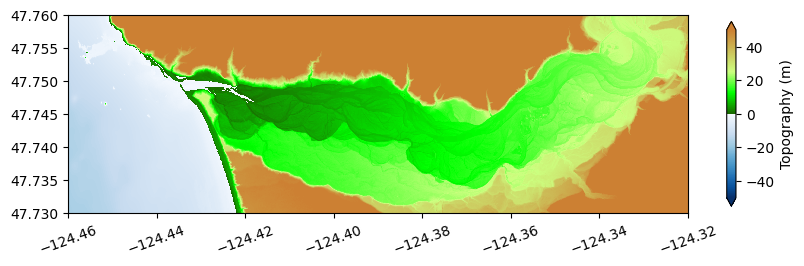

In [14]:
fig,ax = subplots(figsize=(10,8))
Hoh1.plot(axes=ax, limits=(-50,50), add_colorbar=False)
Hoh2.plot(axes=ax, limits=(-50,50), cb_kwargs={'shrink':0.3, 'extend':'both'})
axis(extent)

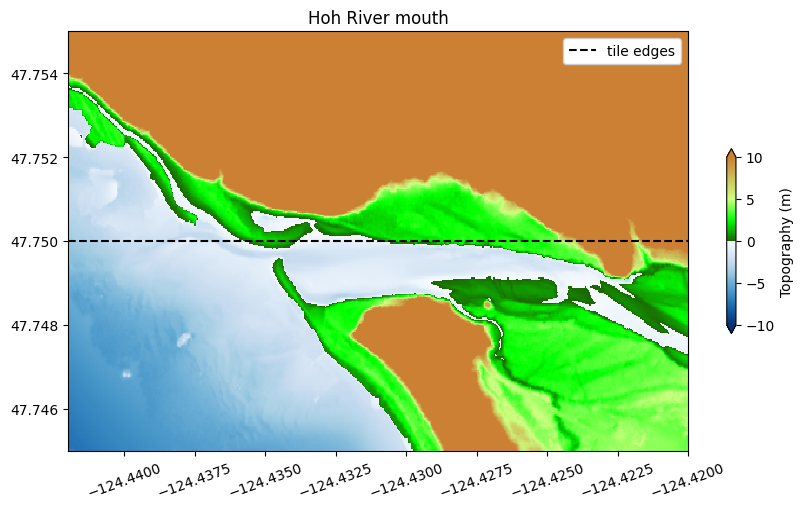

In [15]:
extent2 = [-124.442, -124.42, 47.745, 47.755]
fig,ax = subplots(figsize=(10,8))
Hoh1.plot(axes=ax, limits=(-10,10), add_colorbar=False)
Hoh2.plot(axes=ax, limits=(-10,10), cb_kwargs={'shrink':0.3, 'extend':'both'})
plot(extent2[:2], [47.75, 47.75], 'k--', label='tile edges')
legend(loc='upper right', framealpha=1)
axis(extent2)
title('Hoh River mouth');

In [16]:
Hoh1.y[-3:], Hoh2.y[:3]

(array([47.74992284, 47.7499537 , 47.74998457]),
 array([47.75001543, 47.7500463 , 47.75007716]))

In [17]:
(47.75001543 - 47.74998457)*9*3600

0.9998639998514136

## Missing data

Data is missing on the southern part of this tile at the request of the Quinault Nation.

In [18]:
tile_n47x75_w124x50_2025v2.Z.min()

-9999.0

In [19]:
missing = where(tile_n47x75_w124x50_2025v2.Z == -9999.)
Ymissing = tile_n47x75_w124x50_2025v2.Y[missing[1],missing[0]]
print(f'Missing data south of y = {Ymissing.max()}')

Missing data south of y = 47.7499845678867


<Axes: >

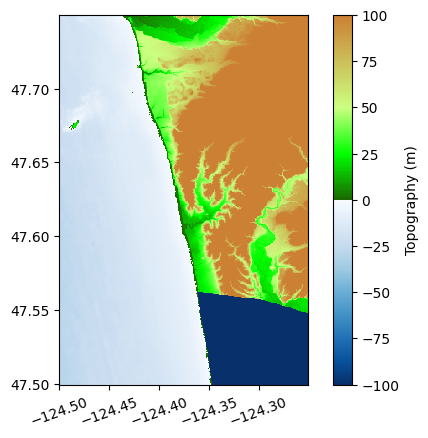

In [20]:
tile_n47x75_w124x50_2025v2.crop(coarsen=18).plot(limits=(-100,100))

In [21]:
zmin = tile_n47x75_w124x50_2025v2.Z.min(axis=1)
j = where(zmin == -9999.)[0].max()
ymissing = tile_n47x75_w124x50_2025v2.y[j]
print(f'Some data is missing below y = {ymissing:.5f}')

Some data is missing below y = 47.56273


## Merge the two tiles

In [22]:
assert abs(tile_n47x75_w124x50_2025v2_mhw.x - tile_n48x00_w124x50_2025v2_mhw.x).max() < 1e-10, \
        '*** x arrays should agree'
dy = 1/(9*3600)
dy_edge = tile_n48x00_w124x50_2025v2_mhw.y[0] - tile_n47x75_w124x50_2025v2_mhw.y[-1]
assert abs(dy_edge - dy) < 0.01*dy, \
       f'*** y arrays should be adjacent with gap {dy}, dy_edge = {dy_edge}'

x = tile_n47x75_w124x50_2025v2_mhw.x
y = hstack((tile_n47x75_w124x50_2025v2_mhw.y, tile_n48x00_w124x50_2025v2_mhw.y))

dys = diff(y)
print(f'y has {len(y)} points with min dy = {dys.min()}, max dy = {dys.max()}')

y has 16200 points with min dy = 3.0864197498203794e-05, max dy = 3.086446204747517e-05


In [23]:
X,Y = meshgrid(x,y)
Z = zeros(X.shape)
topo = topotools.Topography()
topo.set_xyZ(x,y,Z)
print('New topo extent: ', topo.extent)

New topo extent:  (-124.49998456790125, -124.2500154323633, 47.50001543234875, 47.9999845678867)


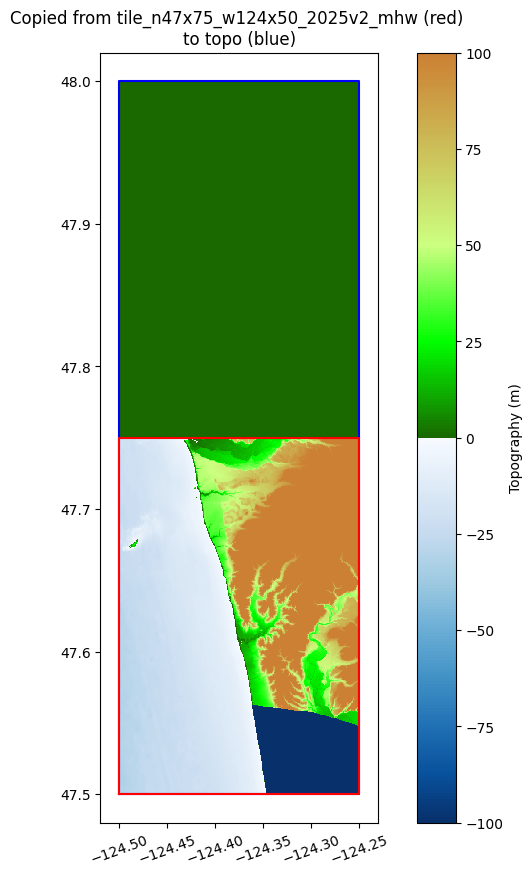

In [24]:
name = 'Hoh_mergedtiles_19s_mhw'
topo = merge_topos.overwrite(topo, tile_n47x75_w124x50_2025v2_mhw)
merge_topos.plot_topos(topo, tile_n47x75_w124x50_2025v2_mhw,
                       'topo','tile_n47x75_w124x50_2025v2_mhw',
                       coarsen=18, limits=(-100,100), buffer=0.02)

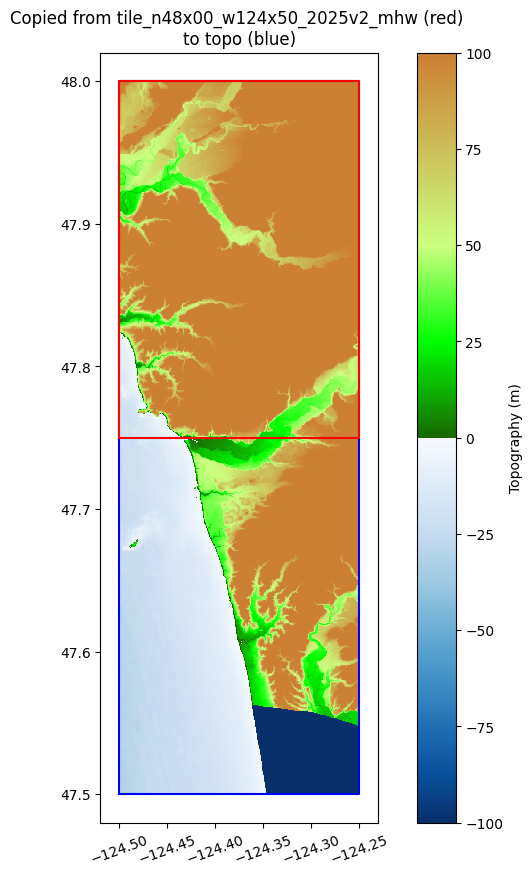

In [25]:
topo = merge_topos.overwrite(topo, tile_n48x00_w124x50_2025v2_mhw)
merge_topos.plot_topos(topo, tile_n48x00_w124x50_2025v2_mhw,
                       'topo','tile_n48x00_w124x50_2025v2_mhw',
                       coarsen=18, limits=(-100,100), buffer=0.02)

In [26]:
#extent_save = [-124.5, -124.35, 47.65, 47.81]
extent_save = [-124.44, -124.39, 47.73, 47.76]
topo_save = topo.crop(extent_save)
fname = 'HohRiver_19s_mhw.asc'
topo_save.write(fname, 3, header_style='asc', Z_format='%.3f')
print(f'Created {fname} with Z.shape = {topo_save.Z.shape}')

Created HohRiver_19s_mhw.asc with Z.shape = (972, 1620)


In [27]:
ls -lh HohRiver_19s_mhw.asc

-rw-r--r--  1 rjl  staff    10M Feb 21 20:42 HohRiver_19s_mhw.asc


Created  HohRiver_19s_mhw.png


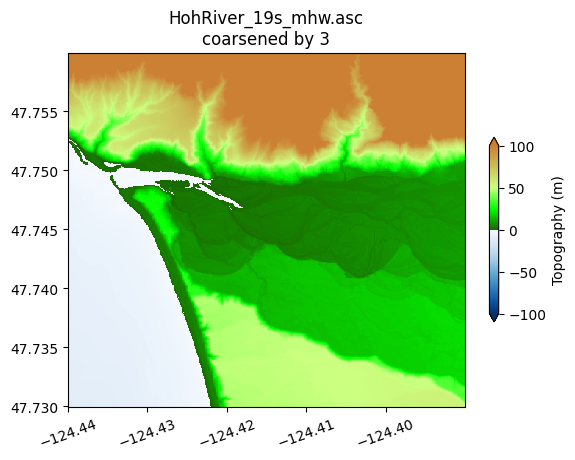

In [28]:
topo_save.crop(coarsen=3).plot(limits=(-100,100), cb_kwargs={'extend':'both','shrink':0.5})
title(f'{fname}\ncoarsened by 3');
fname_png = fname.replace('asc','png')
savefig(fname_png)
print('Created ',fname_png)

## Larger version covering Kalaloch (coarsened to 1/3")

In [29]:
extent_HohKalaloch = [-124.5, -124.35, 47.57, 47.81]
topo_HohKalaloch = topo.crop(extent_HohKalaloch, coarsen=3)
fname = 'HohKalaloch_13s_mhw.asc'
topo_HohKalaloch.write(fname, 3, header_style='asc', Z_format='%.3f')
print(f'Created {fname} with Z.shape = {topo_save.Z.shape}')

Created HohKalaloch_13s_mhw.asc with Z.shape = (972, 1620)


In [30]:
ls -lh HohKalaloch*

-rw-r--r--  1 rjl  staff    31M Feb 21 20:42 HohKalaloch_13s_mhw.asc
-rw-r--r--  1 rjl  staff    59K Feb 13 08:46 HohKalaloch_13s_mhw.png


Created  HohKalaloch_13s_mhw.png


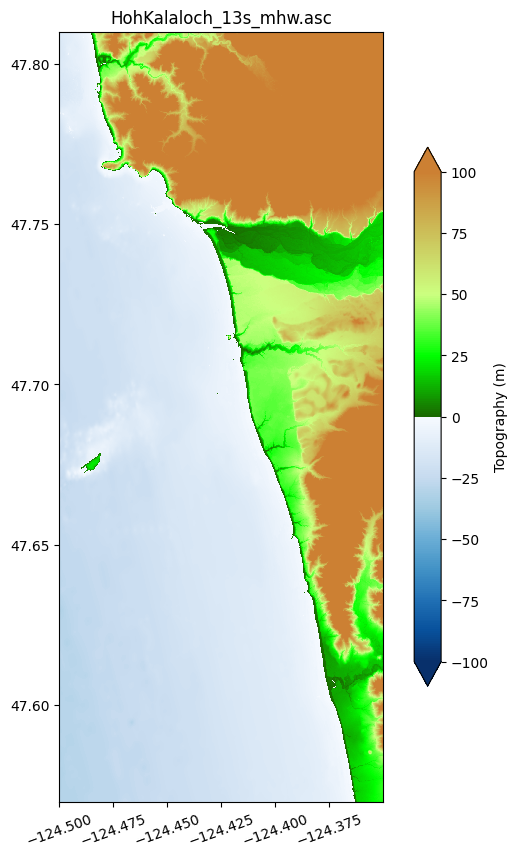

In [31]:
fig,ax = subplots(figsize=(8,10))
topo_HohKalaloch.plot(axes=ax,limits=(-100,100), cb_kwargs={'extend':'both','shrink':0.7})
title(f'{fname}');
fname_png = fname.replace('asc','png')
savefig(fname_png)
print('Created ',fname_png)